In [1]:
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.tensorboard import SummaryWriter

from market_dynamics import bs_delta, bs_call_price

from data import DataFromFile, SimulationData
from utils import call_payoff, stochastic_integral
from models import ControlNet
from train import train_dataset, test, train
from evaluation import get_eval_data
from market_dynamics import bs_delta, bs_generator, bs_call_price

import yfinance as yf
from arch import arch_model
import dask.dataframe as dd

from tqdm import tqdm

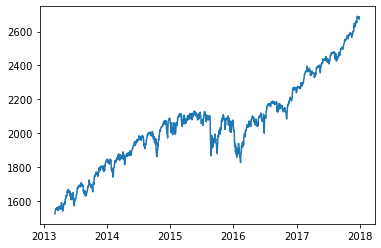

In [28]:
ticker = yf.Ticker('^GSPC')
hist = ticker.history(period='1y', start='2013-03-05', end='2018-01-02')
initial_value = hist.Close.iloc[-1]
rets = 100 * hist.Close.pct_change().dropna()
plt.plot(hist.Close)

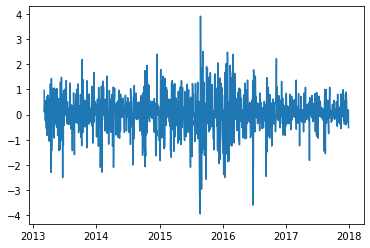

In [29]:
plt.plot(rets)

In [38]:
fit_model = arch_model(rets, p=1, o=1, q=1, dist='t') #Right now fit to full data set, o=1 for gjr-garch
res = fit_model.fit(disp='off')

In [39]:
h_params = {"N_SIM": 2*10 ** 7, #The parameters as specificied in the paper
            "RF": 0,
            "N_DIMS": 3,
            "FC_DIM": 32,
            "LR": 0.005,
            "GAMMA": 1,
            "EPOCHS": 40,
            "EPOCHS_2": 5, 
            "BATCH_SIZE": 10000,}

In [40]:
strike = np.ceil(initial_value * 1.02)
sigma = (res._volatility[-1] / 100) * (252**0.5)
n_steps = 50
price = bs_call_price(n_steps, initial_value, sigma, h_params["RF"], strike)
initial_value, strike, sigma, price

(2673.610107421875, 2728.0, 0.06413026856822653, 7.0684978380948)

In [41]:
#FROM R CODE GJRGARCH_ESTIMATION.R
mu = 0.048758
omega = 0.029968 
alpha = 0.000000
gamma = 0.379722
beta = 0.776090 
nu = 5.582693

In [6]:
sig_lag = np.zeros(2*10**7)
eps_lag = np.random.standard_t(nu, 2*10**7)

In [7]:
def indicator(x):
    return np.where(x<0, 1, 0)

In [8]:
sig_list = [sig_lag]
eps_list = [eps_lag]
ret_list = initial_value*np.ones(2*10**7)

In [9]:
output = pd.DataFrame(ret_list)
output.shape

(20000000, 1)

In [10]:
ret_list = [ret_list]
for i in tqdm(range(1,51)):
    sig_lag = omega + alpha*eps_lag**2 + gamma*indicator(eps_lag)*eps_lag**2 + beta*sig_lag**2
    sig_lag = np.sqrt(sig_lag)
    eps_lag = sig_lag* np.random.standard_t(nu, 2*10**7)
    sig_list.append(sig_lag)
    eps_list.append(eps_lag)
    ret_list.append(eps_lag + mu)
    output[i] = np.exp((eps_lag + mu)/100)
    

100%|█████████████████████████████████████████| 50/50 [02:19<00:00,  2.79s/it]


In [45]:
output.columns = 'v' + output.columns.astype(str)

In [12]:
output.to_parquet('gjr_path.parquet')

In [14]:
output = np.cumprod(output,axis=1)

In [47]:
output.to_parquet('gjr_path__.parquet')

In [17]:
output.min().min()

7.514943155870884e-127

In [46]:
output.head(100)

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v41,v42,v43,v44,v45,v46,v47,v48,v49,v50
0,2673.610107,2667.212638,2680.170741,2680.226636,2680.372947,2679.601395,2698.906805,2704.662132,2705.911747,2697.535544,...,2846.707832,2832.308257,2828.768772,2826.349818,2825.226426,2882.160849,2908.056908,2893.464535,2892.045469,2913.412777
1,2673.610107,2674.700202,2671.181269,2677.036926,2673.997804,2671.805818,2673.785781,2695.963242,2699.352962,2707.977548,...,2859.335935,2824.600271,2872.531932,2814.946322,2839.810455,2917.611823,2922.426003,2890.125888,2894.584236,2923.177762
2,2673.610107,2684.995377,2678.233337,2676.551880,2674.923737,2678.854333,2675.355641,2678.077894,2677.595171,2695.931193,...,2827.785701,2886.381138,2900.023309,2907.584359,2921.479164,2903.979569,2938.591440,2951.334900,2982.732236,2944.540950
3,2673.610107,2678.061674,2677.564385,2688.622220,2687.282496,2686.558405,2691.492038,2688.345321,2662.844290,2664.501136,...,2805.698557,2813.779102,2807.211041,2787.275807,2837.617769,2840.721342,2872.033797,2785.864002,2750.196865,2765.446044
4,2673.610107,2675.318081,2684.078670,2690.902766,2689.000701,2693.655050,2709.241716,2716.577412,2727.777769,2740.714042,...,2751.293312,2743.392508,2710.562207,2709.360095,2723.208047,2731.696637,2676.691481,2676.521263,2698.577105,2714.036059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2673.610107,2684.814944,2667.105886,2660.976672,2624.483476,2614.258717,2669.163120,2654.095777,2645.777835,2646.698416,...,2816.830718,2801.108617,2804.616335,2817.992005,2834.852644,2836.928312,2809.090325,2826.525789,2820.908914,2836.091356
96,2673.610107,2717.700558,2650.699533,2527.847440,2463.447859,2639.648925,2591.096303,2550.285515,2390.459769,2505.873490,...,3059.770652,2983.030474,3113.438376,3013.796654,3156.779786,3135.472186,3115.629680,3090.144944,3218.381587,3288.551385
97,2673.610107,2675.166635,2706.307830,2708.233625,2708.840060,2729.487652,2732.393979,2713.365421,2740.327440,2707.257272,...,2932.106690,2915.856336,2925.322109,2899.743372,2891.526094,2901.438794,2877.875590,2838.099774,2871.039526,2819.161973
98,2673.610107,2678.015045,2661.124682,2649.692135,2645.177016,2665.654596,2659.702744,2655.895565,2639.287511,2641.270254,...,2563.106341,2528.857760,2510.968789,2436.206194,2378.375498,2305.462719,2451.971562,2428.797407,2411.793878,2299.653979


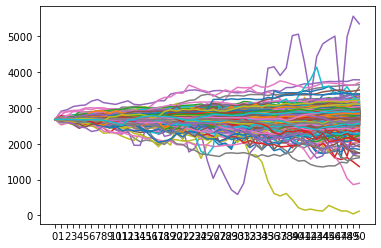

In [23]:
for i in range(100,800):
    plt.plot(output.iloc[i,:])
plt.show()

In [48]:
dt = DataFromFile("gjr_path__.parquet", "./batch_files/", 10000, h_params["N_SIM"], price, call_payoff, {"strike": strike})

TypeError: expected list of bytes

In [ ]:
cn = ControlNet(n_steps, 1, [32, 32, 32], 1, learn_price=False)
optimizer = Adam(cn.parameters(), lr=h_params["LR"])
scheduler = ExponentialLR(optimizer, gamma=0.99)
criterion = torch.nn.MSELoss()

In [ ]:
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
comment = ""
log_dir = os.path.join('experiments', current_time + '_' + comment)
writer = SummaryWriter(log_dir)

os.chdir(origin_path)
train_dataset(dt, cn, criterion, optimizer, 20, writer, scheduler)